## Data Exploration 2
### studentsperformance

In [36]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

### Upload data from sql

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

studentsperformance_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
studentsperformance_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Any missing data?

In [4]:
studentsperformance_df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

### Distribution of the data

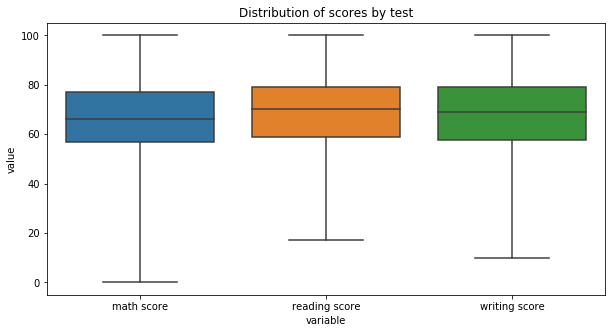

In [5]:
columns = [column_name for column_name in studentsperformance_df.columns]

student_test_data = pd.melt(studentsperformance_df,value_vars=columns[5:])

fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(x='variable',y='value',data=student_test_data, whis=5)
ax.set_title('Distribution of scores by test')

plt.xticks(rotation=0)
plt.show()

### winsorize data

In [6]:
winsorized_math = winsorize(studentsperformance_df['math score'], (0, 0.05))
winsorized_reading = winsorize(studentsperformance_df['reading score'], (0, 0.05))
winsorized_writing = winsorize(studentsperformance_df['writing score'], (0, 0.05))

### Question 1

Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

#### Gender

In [7]:
#create a melt table
gender_melt = pd.melt(studentsperformance_df,id_vars=['gender'],\
                              value_vars=['math score','reading score','writing score'],\
                                 var_name='test',value_name='score')
gender_melt.head()
               

,gender,test,score
0,female,math score,72
1,female,math score,69
2,female,math score,90
3,male,math score,47
4,male,math score,76


In [9]:
#make the pivot table 
gender_mean = pd.pivot_table(gender_melt,index='gender',columns='test',values='score',aggfunc='mean')
gender_mean



test,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


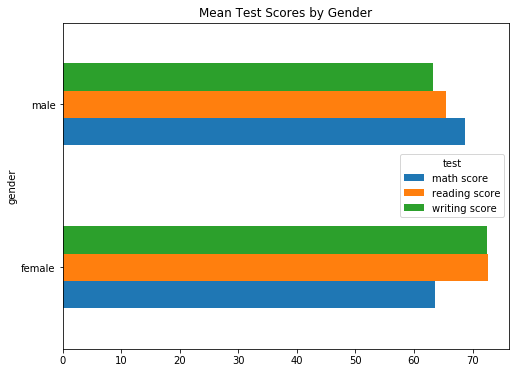

In [118]:
gender_mean.plot(kind='barh',figsize=(8,6),title='Mean Test Scores by Gender')
plt.show()

In [80]:
females = studentsperformance_df[studentsperformance_df['gender']=='female']
males = studentsperformance_df[studentsperformance_df['gender']=='male']

for test in columns[5:]:
    print(str(test) + (' ') + str(ttest_ind(males[test],females[test])))

math score Ttest_indResult(statistic=5.383245869828983, pvalue=9.120185549328822e-08)
reading score Ttest_indResult(statistic=-7.959308005187657, pvalue=4.680538743933289e-15)
writing score Ttest_indResult(statistic=-9.979557910004507, pvalue=2.019877706867934e-22)


From the data it appears that males do better on average in math, while females score higher on average in reading and writing. The p-values are very low showing the differences in means are likely not a result of randomness.

#### Ethnicity

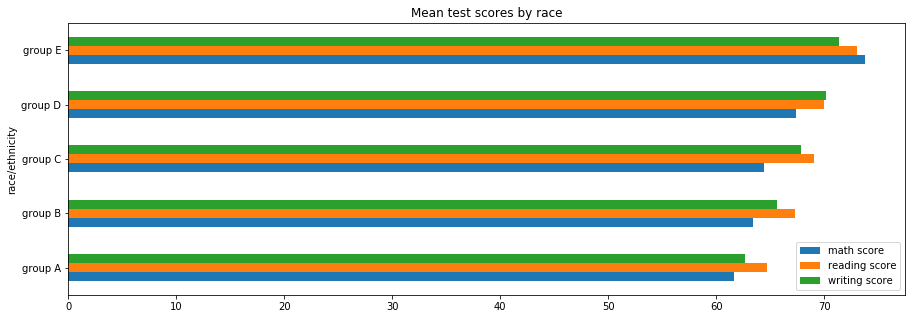

In [13]:
by_race = studentsperformance_df.groupby('race/ethnicity').mean()

by_race.plot(kind='barh',figsize=(15,5),title='Mean test scores by race')
plt.show()

In [88]:
ethnicities = studentsperformance_df["race/ethnicity"].unique()
grouped_df = studentsperformance_df.groupby("race/ethnicity")
for var in ["math score", "reading score", "writing score"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(ethnicities)):
        for j in range(i+1, len(ethnicities)):
            print(
                "t-test between groups {0} and {1}:".format(ethnicities[i], ethnicities[j]))
            print(ttest_ind(
                studentsperformance_df[studentsperformance_df["race/ethnicity"]
                           == ethnicities[i]][var],
                studentsperformance_df[studentsperformance_df["race/ethnicity"] == ethnicities[j]][var]
            ))
            
            

------------------------------------------------
Comparisons for variable: math score
------------------------------------------------
t-test between groups group B and group C:
Ttest_indResult(statistic=-0.7315669893534263, pvalue=0.4647708939167453)
t-test between groups group B and group A:
Ttest_indResult(statistic=0.9355076279747488, pvalue=0.3503415961659957)
t-test between groups group B and group D:
Ttest_indResult(statistic=-2.82845539712675, pvalue=0.004886197137104194)
t-test between groups group B and group E:
Ttest_indResult(statistic=-6.007397050552227, pvalue=5.007946047497971e-09)
t-test between groups group C and group A:
Ttest_indResult(statistic=1.5997220303217299, pvalue=0.11043810745588042)
t-test between groups group C and group D:
Ttest_indResult(statistic=-2.41858624746011, pvalue=0.015888349556016285)
t-test between groups group C and group E:
Ttest_indResult(statistic=-6.127642520822135, pvalue=1.927238849552764e-09)
t-test between groups group A and group D:


Group E appears to show higher scores across the board followed by group D and C. Group A appears to show the lowest scores of any race.

#### parental level of education

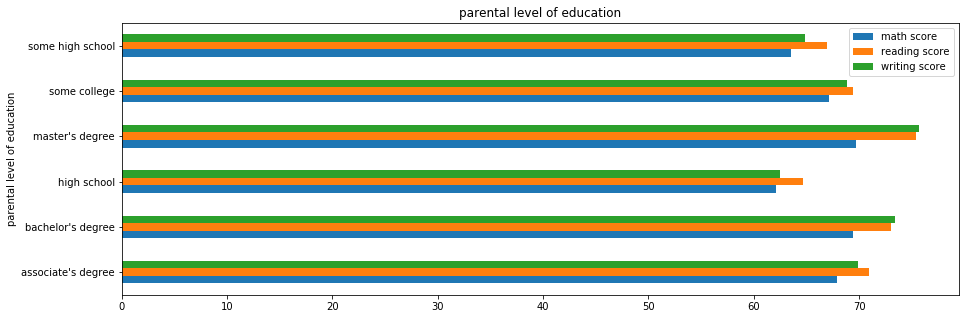

In [14]:
parent_level = studentsperformance_df.groupby('parental level of education').mean()

parent_level.plot(kind='barh',figsize=(15,5),title='parental level of education')
plt.show()

In [90]:
ethnicities = studentsperformance_df["parental level of education"].unique()
grouped_df = studentsperformance_df.groupby("parental level of education")
for var in ["math score", "reading score", "writing score"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(ethnicities)):
        for j in range(i+1, len(ethnicities)):
            print(
                "t-test between groups {0} and {1}:".format(ethnicities[i], ethnicities[j]))
            print(ttest_ind(
                studentsperformance_df[studentsperformance_df["parental level of education"]
                           == ethnicities[i]][var],
                studentsperformance_df[studentsperformance_df["parental level of education"]
                           == ethnicities[j]][var]
            ))
            

------------------------------------------------
Comparisons for variable: math score
------------------------------------------------
t-test between groups bachelor's degree and some college:
Ttest_indResult(statistic=1.3702352829617477, pvalue=0.17151224218471559)
t-test between groups bachelor's degree and master's degree:
Ttest_indResult(statistic=-0.14868196568849312, pvalue=0.8819757824867702)
t-test between groups bachelor's degree and associate's degree:
Ttest_indResult(statistic=0.8786641889793243, pvalue=0.38020757818036177)
t-test between groups bachelor's degree and high school:
Ttest_indResult(statistic=4.236143622484822, pvalue=2.9965345853843376e-05)
t-test between groups bachelor's degree and some high school:
Ttest_indResult(statistic=3.196718602676573, pvalue=0.0015409192922812146)
t-test between groups some college and master's degree:
Ttest_indResult(statistic=-1.2356334215824571, pvalue=0.21761956810347416)
t-test between groups some college and associate's degree:

From the data it appears that students who had parents with master's degrees scored the highest followed by bachelor's degresss and associates. Some high school appears to show higher scores than just high school.

### Question 2

Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?

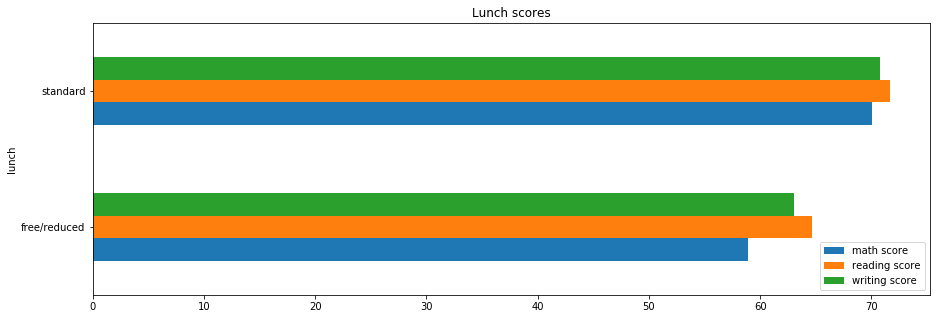

In [18]:
studentsperformance_df.groupby('lunch').mean().plot(kind='barh',figsize=(15,5),title='Lunch scores')
plt.show()

In [91]:
standard = studentsperformance_df[studentsperformance_df['lunch']=='standard']
reduced = studentsperformance_df[studentsperformance_df['lunch']=='free/reduced']

for test in columns[5:]:
    print(str(test) + (' ') + str(ttest_ind(standard[test],reduced[test])))

math score Ttest_indResult(statistic=11.837180472914612, pvalue=2.4131955993137074e-30)
reading score Ttest_indResult(statistic=7.451056467473455, pvalue=2.0027966545279011e-13)
writing score Ttest_indResult(statistic=8.009784197834758, pvalue=3.186189583166477e-15)


The data appears to show that standard lunch students score higher on all three exams on average.

### Question 3

Does the test preparation course seem to have an effect on the exam performances?

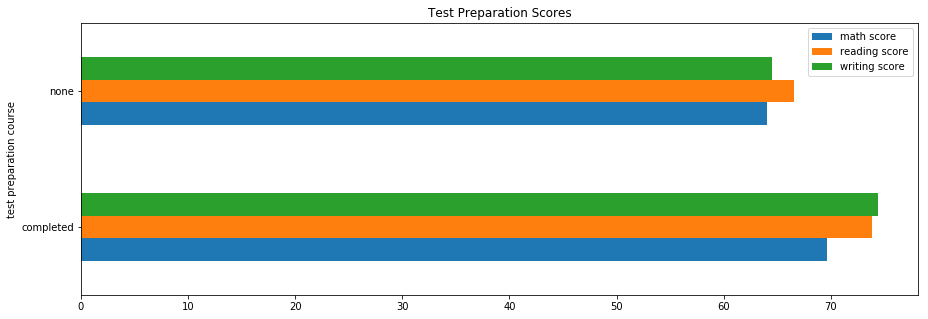

In [20]:
studentsperformance_df.groupby('test preparation course').mean().\
                        plot(kind='barh',figsize=(15,5),title='Test Preparation Scores')
plt.show()



In [92]:
none = studentsperformance_df[studentsperformance_df['test preparation course']=='none']
completed = studentsperformance_df[studentsperformance_df['test preparation course']=='completed']

for test in columns[5:]:
    print(str(test) + (' ') + str(ttest_ind(none[test],completed[test])))

math score Ttest_indResult(statistic=-5.704616417349102, pvalue=1.5359134607147415e-08)
reading score Ttest_indResult(statistic=-7.871663538941468, pvalue=9.081783336892205e-15)
writing score Ttest_indResult(statistic=-10.409173436808748, pvalue=3.68529173524572e-24)


Completing a test preparation course appears to show better outcomes on mean test scores according to the data.

### Question 3

Which 2 exam scores are most correlated with each other?

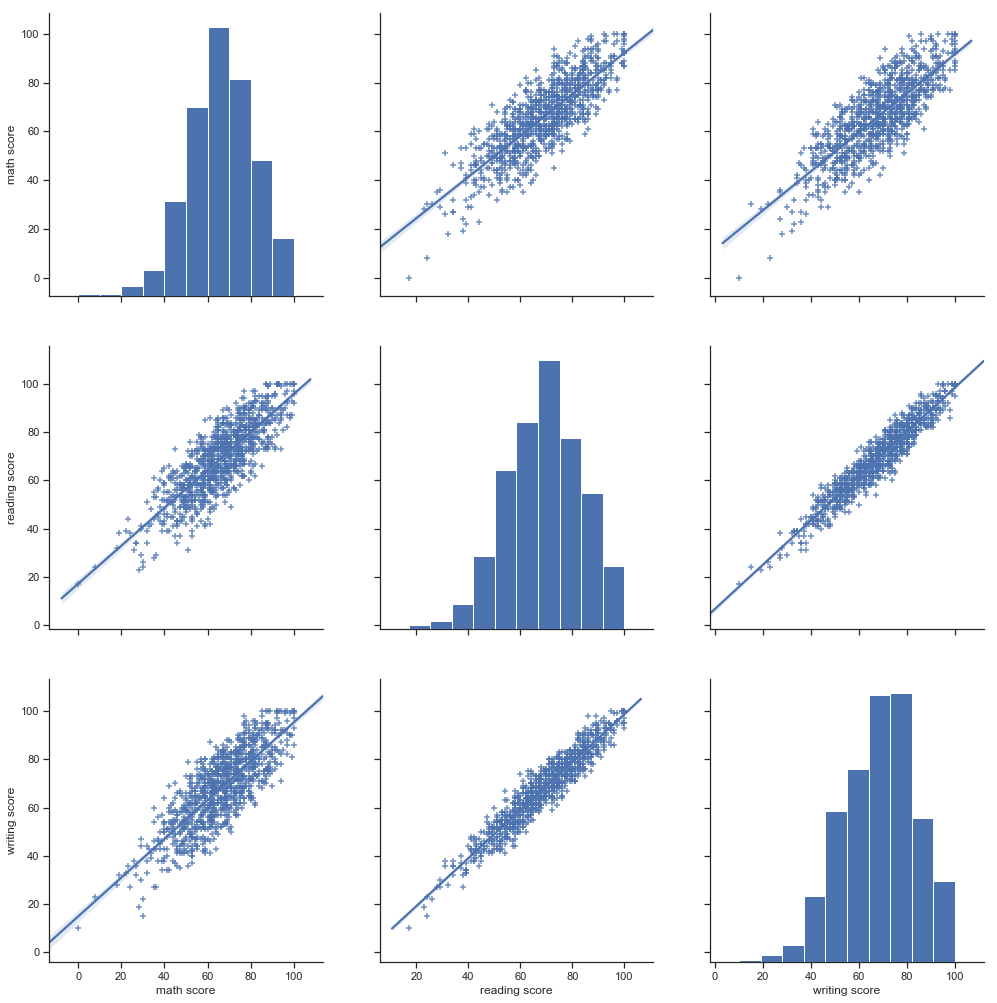

In [33]:
data_pairplot = studentsperformance_df[['gender','math score','reading score','writing score']]

g=sns.pairplot(data_pairplot, kind='reg',markers='+')
g.fig.set_size_inches(15,15)

plt.show()

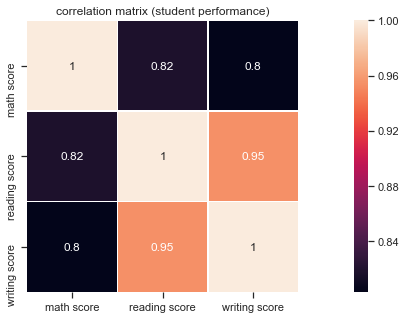

In [35]:
corrmat_student = studentsperformance_df.corr()

plt.figure(figsize=(20,5))

sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

It appears that reading and writing scores are most strongly correlated with eachother.